[*********************100%***********************]  6 of 6 completed



Benchmark Portfolio Summary:
  Ticker           Company Name                  Sector                        Industry  Weight  Annual Return  Volatility  Sharpe Ratio  Contribution
2   GOOG          Alphabet Inc.  Communication Services  Internet Content & Information     0.5       0.231969    0.323928      0.716112      0.115984
1   MSFT  Microsoft Corporation              Technology       Software - Infrastructure     0.3       0.226391    0.305068      0.742099      0.067917
0   AAPL             Apple Inc.              Technology            Consumer Electronics     0.2       0.283132    0.316891      0.893467      0.056626

Benchmark Portfolio Metrics:
              Metric     Value
0  Cumulative Return  2.057606
1      Annual Return  0.251369
2         Volatility  0.287480
3       Sharpe Ratio  0.874388
4       Max Drawdown -0.375530

Optimized Portfolio Summary:
  Ticker           Company Name                  Sector                        Industry   Weight  Annual Return  Volatil

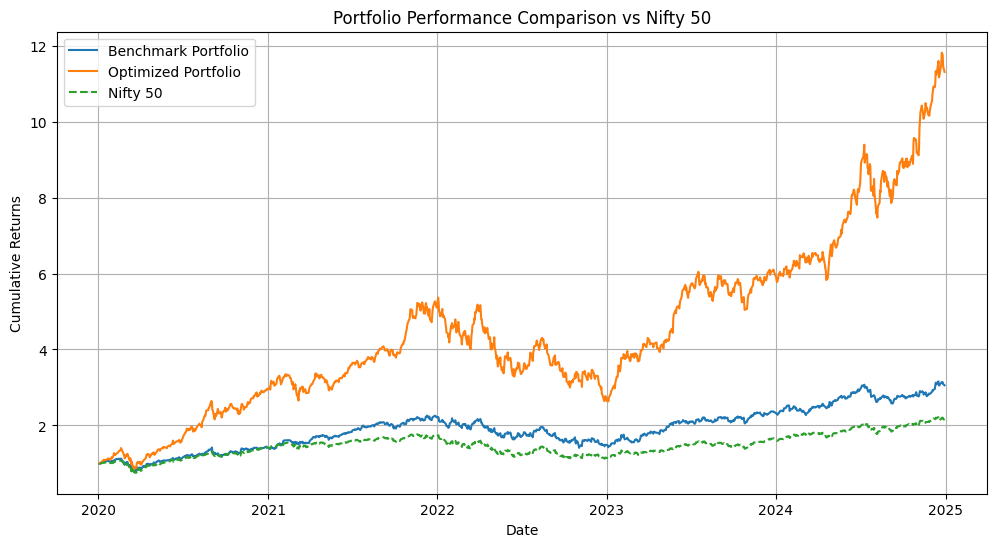

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List

class PortfolioBenchmark:
    def __init__(self, start_date: str, end_date: str):

        self.start_date = start_date
        self.end_date = end_date
        self.stock_info = {}
        self.nifty_data = None
        
    def _get_stock_info(self, ticker: str) -> dict:

        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            return {
                'name': info.get('longName', ticker),
                'sector': info.get('sector', 'N/A'),
                'industry': info.get('industry', 'N/A')
            }
        except:
            return {
                'name': ticker,
                'sector': 'N/A',
                'industry': 'N/A'
            }
    def download_data(self, tickers: List[str]) -> pd.DataFrame:

        return yf.download(tickers, start=self.start_date, end=self.end_date)['Close']
    
    # Get nifty data

    def get_nifty_data(self) -> pd.Series:

        if self.nifty_data is None:
            nifty = yf.Ticker("^IXIC")
            self.nifty_data = nifty.history(start=self.start_date, end=self.end_date)['Close'].pct_change().dropna()
        return self.nifty_data


    def create_portfolio_summary(self, 
                               weights: Dict[str, float], 
                               returns: pd.DataFrame,
                               metrics: dict) -> pd.DataFrame:

        summary_data = []
        
        for ticker, weight in weights.items():
            if ticker not in self.stock_info:
                self.stock_info[ticker] = self._get_stock_info(ticker)
                
            stock_returns = returns[ticker]
            annual_return = (1 + stock_returns).prod() ** (252/len(returns)) - 1
            volatility = stock_returns.std() * np.sqrt(252)
            sharpe = annual_return / volatility if volatility != 0 else 0
            
            summary_data.append({
                'Ticker': ticker,
                'Company Name': self.stock_info[ticker]['name'],
                'Sector': self.stock_info[ticker]['sector'],
                'Industry': self.stock_info[ticker]['industry'],
                'Weight': weight,
                'Annual Return': annual_return,
                'Volatility': volatility,
                'Sharpe Ratio': sharpe,
                'Contribution': weight * annual_return
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.sort_values('Weight', ascending=False, inplace=True)
        
        # Add portfolio-level metrics
        portfolio_metrics = pd.DataFrame({
            'Metric': list(metrics.keys()),
            'Value': list(metrics.values())
        })
        
        return summary_df, portfolio_metrics
        
    def analyze_custom_portfolio(self, 
                               weights: Dict[str, float], 
                               data: pd.DataFrame = None) -> Tuple[dict, pd.DataFrame]:

        if data is None:
            data = yf.download(list(weights.keys()), 
                             start=self.start_date, 
                             end=self.end_date)['Close']
        
        returns = data.pct_change().dropna()
        
        # Calculate portfolio returns
        portfolio_returns = pd.Series(0, index=returns.index)
        for ticker, weight in weights.items():
            portfolio_returns += returns[ticker] * weight
            
        # Calculate metrics
        cumulative_return = (1 + portfolio_returns).prod() - 1
        annual_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
        volatility = portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / volatility
        max_drawdown = ((1 + portfolio_returns).cumprod() / 
                       (1 + portfolio_returns).cumprod().cummax() - 1).min()
        
        metrics = {
            'Cumulative Return': cumulative_return,
            'Annual Return': annual_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown
        }
        
        return metrics, returns, portfolio_returns
    
    def optimize_portfolio(self, 
                         original_weights: Dict[str, float], 
                         additional_stocks: List[str] = None,
                         remove_underperforming: bool = True) -> Tuple[dict, dict, dict]:

        # Get data for original portfolio and additional stocks
        all_tickers = list(original_weights.keys())
        if additional_stocks:
            all_tickers.extend(additional_stocks)
            
        data = yf.download(all_tickers, start=self.start_date, end=self.end_date)['Close']
        
        # Analyze original portfolio
        original_metrics, original_stock_returns, original_portfolio_returns = \
            self.analyze_custom_portfolio(original_weights, data[list(original_weights.keys())])
        
        # Create benchmark summary
        benchmark_summary, benchmark_metrics = self.create_portfolio_summary(
            original_weights, original_stock_returns, original_metrics)
        
        # Optimize portfolio
        mean_returns = expected_returns.mean_historical_return(data)
        cov_matrix = risk_models.sample_cov(data)
        
        ef = EfficientFrontier(mean_returns, cov_matrix)
        
        # Add constraints
        if not remove_underperforming:
            for ticker in original_weights.keys():
                ef.add_constraint(lambda x: x[all_tickers.index(ticker)] >= 0.01)
        
        ef.add_constraint(lambda x: x <= 0.3)
        
        # Optimize for Sharpe ratio
        optimized_weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        
        # Calculate metrics for optimized portfolio
        optimized_metrics, optimized_stock_returns, optimized_portfolio_returns = \
            self.analyze_custom_portfolio(cleaned_weights, data)
        
        # Nifty 50 comparison
        nifty_returns = self.get_nifty_data()
        cumulative_nifty = (1 + nifty_returns).prod() - 1
        annual_nifty = (1 + cumulative_nifty) ** (252 / len(nifty_returns)) - 1
        volatility_nifty = nifty_returns.std() * np.sqrt(252)
        sharpe_nifty = annual_nifty / volatility_nifty
        max_drawdown_nifty = ((1 + nifty_returns).cumprod() /
                              (1 + nifty_returns).cumprod().cummax() - 1).min()
               
        # Create optimized summary
        optimized_summary, optimized_metrics_df = self.create_portfolio_summary(
            cleaned_weights, optimized_stock_returns, optimized_metrics)
        
        nifty_metrics = {
            'Cumulative Return': cumulative_nifty,
            'Annual Return': annual_nifty,
            'Volatility': volatility_nifty,
            'Sharpe Ratio': sharpe_nifty,
            'Max Drawdown': max_drawdown_nifty
        }
        
        # Create comparison DataFrame
        comparison = self.create_comparison_summary(
            benchmark_summary, optimized_summary, 
            original_metrics, optimized_metrics,
            nifty_metrics)
        
        return {
            'benchmark_summary': benchmark_summary,
            'benchmark_metrics': benchmark_metrics,
            'optimized_summary': optimized_summary,
            'optimized_metrics': optimized_metrics_df,
            'comparison': comparison,
            'benchmark_returns': original_portfolio_returns,
            'optimized_returns': optimized_portfolio_returns,
            'nifty_returns': nifty_returns,
            'nifty_metrics': nifty_metrics
        }
    
    def create_comparison_summary(self,
                                benchmark_df: pd.DataFrame,
                                optimized_df: pd.DataFrame,
                                benchmark_metrics: dict,
                                optimized_metrics: dict,
                                nifty_metrics: dict) -> pd.DataFrame:

        # Compare stocks and weights
        all_stocks = sorted(list(set(benchmark_df['Ticker'].tolist() + 
                                   optimized_df['Ticker'].tolist())))
        
        comparison_data = []
        for stock in all_stocks:
            bench_data = benchmark_df[benchmark_df['Ticker'] == stock].iloc[0] \
                if stock in benchmark_df['Ticker'].values else None
            opt_data = optimized_df[optimized_df['Ticker'] == stock].iloc[0] \
                if stock in optimized_df['Ticker'].values else None
            
            comparison_data.append({
                'Ticker': stock,
                'Company Name': bench_data['Company Name'] if bench_data is not None 
                    else opt_data['Company Name'],
                'Benchmark Weight': bench_data['Weight'] if bench_data is not None else 0,
                'Optimized Weight': opt_data['Weight'] if opt_data is not None else 0,
                'Weight Change': (opt_data['Weight'] if opt_data is not None else 0) - 
                               (bench_data['Weight'] if bench_data is not None else 0),
                'Benchmark Return': bench_data['Annual Return'] if bench_data is not None else None,
                'Optimized Return': opt_data['Annual Return'] if opt_data is not None else None,
                'Return Difference': (opt_data['Annual Return'] if opt_data is not None else 0) -
                                   (bench_data['Annual Return'] if bench_data is not None else 0)
            })
            
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df.sort_values('Weight Change', ascending=False, inplace=True)
        
        return comparison_df

    def plot_comparison(self, 
                       benchmark_returns: pd.Series, 
                       optimized_returns: pd.Series,
                       nifty_returns: pd.Series):

        plt.figure(figsize=(12, 6))
        
        cumul_benchmark = (1 + benchmark_returns).cumprod()
        cumul_optimized = (1 + optimized_returns).cumprod()
        cumul_nifty = (1 + nifty_returns).cumprod()
        
        plt.plot(cumul_benchmark, label='Benchmark Portfolio')
        plt.plot(cumul_optimized, label='Optimized Portfolio')
        plt.plot(cumul_nifty, label='Nifty 50', linestyle='--')
        
        plt.title('Portfolio Performance Comparison vs Nifty 50')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.grid(True)
        plt.show()

def main():
    # Define custom portfolio
    custom_portfolio = {
        'AAPL': 0.2,
        'MSFT': 0.3,
        'GOOG': 0.5
    }
    
    # Additional stocks to consider
    additional_stocks = ['TSLA', 'NVDA', 'META']
    
    # Initialize benchmark analyzer
    benchmark = PortfolioBenchmark('2020-01-01', '2024-12-31')
    
    # Run optimization
    results = benchmark.optimize_portfolio(
        custom_portfolio, 
        additional_stocks=additional_stocks
    )
    
    # Print detailed results
    print("\nBenchmark Portfolio Summary:")
    print(results['benchmark_summary'].to_string())
    
    print("\nBenchmark Portfolio Metrics:")
    print(results['benchmark_metrics'].to_string())
    
    print("\nOptimized Portfolio Summary:")
    print(results['optimized_summary'].to_string())
    
    print("\nOptimized Portfolio Metrics:")
    print(results['optimized_metrics'].to_string())

    print("\nNifty 50 Metrics:")
    print(results['nifty_metrics'])
    
    print("\nPortfolio Comparison:")
    print(results['comparison'].to_string())
    
    # Plot the comparison
    benchmark.plot_comparison(
        results['benchmark_returns'],
        results['optimized_returns'],
        results['nifty_returns']
    )

if __name__ == "__main__":
    main()